In [12]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from tqdm import tqdm
from torchmetrics.functional.regression import (
    mean_absolute_error,
    mean_squared_error,
    r2_score,
)


In [13]:
filename = "../DATA/oil_price.csv"
priceDF = pd.read_csv(filename, encoding="utf-8", parse_dates=["date"])
priceDF.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7291 entries, 0 to 7290
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   date    7291 non-null   datetime64[ns]
 1   price   7291 non-null   float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 114.0 KB


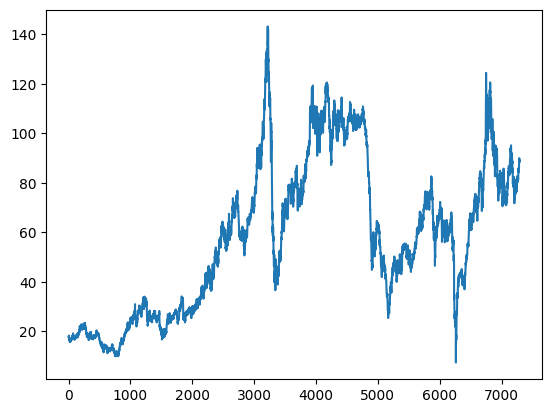

In [14]:
plt.plot(priceDF["price"], label="price")
plt.show()


In [15]:
class OilPriceDataset(Dataset):
    def __init__(self, data, step=30):
        data = data if isinstance(data, np.ndarray) else data.values
        self.max_data = np.max(data)
        self.min_data = np.min(data)
        self.data = (data - self.min_data) / (self.max_data - self.min_data)
        self.data = torch.FloatTensor(self.data)
        self.step = step

    def __len__(self):
        return len(self.data) - self.step

    def __getitem__(self, i):
        data = self.data[i : i + self.step]
        label = self.data[i + self.step]
        return data, label


In [53]:
class OilPriceModel(nn.Module):
    def __init__(self, hidden_size, num_layers, step=30):
        super().__init__()
        self.rnn = nn.GRU(
            input_size=step,
            hidden_size=hidden_size,
            num_layers=num_layers,
            batch_first=True,
        )
        self.fc = nn.Linear(in_features=hidden_size, out_features=1)

    def forward(self, x):
        x, _ = self.rnn(x)
        x = x.reshape(x.shape[0], -1)
        x = self.fc(x)
        return torch.flatten(x)


In [54]:
device = "cuda" if torch.cuda.is_available() else "cpu"
hidden_size = 64
num_layers = 4
step = 30
batch_size = 32

model = OilPriceModel(hidden_size, num_layers, step).to(device)
dataset = OilPriceDataset(priceDF["price"], step)
loader = DataLoader(dataset, batch_size)
optimizer = optim.AdamW(model.parameters(), lr=0.01)
loss_fn = nn.MSELoss()
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer)

len(loader)


227

In [55]:
def learning(epochs, epoch, model, loader, optimizer, loss_fn, is_train=True):
    if is_train:
        model.train()
    else:
        model.eval()

    lossList, maeList, mseList, r2List = [], [], [], []
    with torch.set_grad_enabled(is_train):
        pbar = tqdm(loader, total=len(loader))
        for data, label in pbar:
            pred = model(data.to(device))
            loss = torch.sqrt(loss_fn(pred, label.to(device)))
            lossList.append(loss.item())
            maeList.append(mean_absolute_error(pred, label.to(device)).item())
            mseList.append(mean_squared_error(pred, label.to(device)).item())
            r2List.append(r2_score(pred, label.to(device)).item())
            if is_train:
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()
                pbar.set_description(
                    f"Epoch: {epoch}/{epochs} | Loss: {loss.item():.6f}"
                )
    return np.mean(lossList), np.mean(maeList), np.mean(mseList), np.mean(r2List)


In [57]:
pre_r2 = 0
pre_loss = 100
lossList, maeList, mseList, r2List = [], [], [], []


In [58]:
epochs = 500
for epoch in range(epochs):
    loss, mae, mse, r2 = learning(
        epochs, epoch, model, loader, optimizer, loss_fn, is_train=True
    )
    if epoch % 10 == 9:
        print(
            f"  ==== Loss: {loss:.6f} | MAE: {mae:.6f} | MSE: {mse:.6f} | R2: {r2:.6f} ===="
        )
    if pre_r2 < r2 or (pre_r2 <= r2 and pre_loss > loss):
        torch.save(model, "oil_price_model.pth")
        print(f"Model Saved! => R2: {r2:.6f} | Loss: {loss:.6f}")
        pre_r2 = r2
        pre_loss = loss
    lossList.append(loss), maeList.append(mae), mseList.append(mse), r2List.append(r2)
    scheduler.step(loss)


Epoch: 0/500 | Loss: 0.144130: 100%|██████████| 227/227 [00:06<00:00, 34.24it/s]
Epoch: 1/500 | Loss: 0.143418: 100%|██████████| 227/227 [00:06<00:00, 34.11it/s]
Epoch: 2/500 | Loss: 0.135282: 100%|██████████| 227/227 [00:07<00:00, 29.91it/s]
Epoch: 3/500 | Loss: 0.112825: 100%|██████████| 227/227 [00:07<00:00, 31.28it/s]
Epoch: 4/500 | Loss: 0.098347: 100%|██████████| 227/227 [00:07<00:00, 29.83it/s]
Epoch: 5/500 | Loss: 0.094314: 100%|██████████| 227/227 [00:07<00:00, 30.97it/s]
Epoch: 6/500 | Loss: 0.086634: 100%|██████████| 227/227 [00:07<00:00, 31.16it/s]
Epoch: 7/500 | Loss: 0.098761: 100%|██████████| 227/227 [00:07<00:00, 30.55it/s]
Epoch: 8/500 | Loss: 0.087302: 100%|██████████| 227/227 [00:07<00:00, 30.35it/s]
Epoch: 9/500 | Loss: 0.045955: 100%|██████████| 227/227 [00:07<00:00, 29.75it/s]


  ==== Loss: 0.128828 | MAE: 0.126833 | MSE: 0.031211 | R2: -276.232268 ====


Epoch: 10/500 | Loss: 0.026041: 100%|██████████| 227/227 [00:07<00:00, 30.38it/s]
Epoch: 11/500 | Loss: 0.063296: 100%|██████████| 227/227 [00:07<00:00, 29.98it/s]
Epoch: 12/500 | Loss: 0.143407: 100%|██████████| 227/227 [00:07<00:00, 29.27it/s]
Epoch: 13/500 | Loss: 0.122245: 100%|██████████| 227/227 [00:07<00:00, 29.20it/s]
Epoch: 14/500 | Loss: 0.111179: 100%|██████████| 227/227 [00:07<00:00, 29.15it/s]
Epoch: 15/500 | Loss: 0.108124: 100%|██████████| 227/227 [00:07<00:00, 28.90it/s]
Epoch: 16/500 | Loss: 0.107044: 100%|██████████| 227/227 [00:07<00:00, 28.86it/s]
Epoch: 17/500 | Loss: 0.107351: 100%|██████████| 227/227 [00:07<00:00, 28.93it/s]
Epoch: 18/500 | Loss: 0.108667: 100%|██████████| 227/227 [00:08<00:00, 28.22it/s]
Epoch: 19/500 | Loss: 0.106082: 100%|██████████| 227/227 [00:08<00:00, 26.79it/s]


  ==== Loss: 0.152616 | MAE: 0.150035 | MSE: 0.040688 | R2: -732.937953 ====


Epoch: 20/500 | Loss: 0.030049: 100%|██████████| 227/227 [00:08<00:00, 25.40it/s]
Epoch: 21/500 | Loss: 0.031173: 100%|██████████| 227/227 [00:08<00:00, 25.33it/s]
Epoch: 22/500 | Loss: 0.029347: 100%|██████████| 227/227 [00:09<00:00, 24.23it/s]
Epoch: 23/500 | Loss: 0.023686: 100%|██████████| 227/227 [00:09<00:00, 23.40it/s]
Epoch: 24/500 | Loss: 0.028358: 100%|██████████| 227/227 [00:10<00:00, 22.11it/s]
Epoch: 25/500 | Loss: 0.028445: 100%|██████████| 227/227 [00:09<00:00, 23.97it/s]
Epoch: 26/500 | Loss: 0.030503: 100%|██████████| 227/227 [00:08<00:00, 26.12it/s]
Epoch: 27/500 | Loss: 0.034992: 100%|██████████| 227/227 [00:08<00:00, 27.28it/s]
Epoch: 28/500 | Loss: 0.038126: 100%|██████████| 227/227 [00:07<00:00, 28.39it/s]
Epoch: 29/500 | Loss: 0.046263: 100%|██████████| 227/227 [00:07<00:00, 28.91it/s]


  ==== Loss: 0.070469 | MAE: 0.067452 | MSE: 0.008030 | R2: -141.542371 ====


Epoch: 30/500 | Loss: 0.050840: 100%|██████████| 227/227 [00:07<00:00, 29.40it/s]
Epoch: 31/500 | Loss: 0.051187: 100%|██████████| 227/227 [00:07<00:00, 29.57it/s]
Epoch: 32/500 | Loss: 0.051140: 100%|██████████| 227/227 [00:07<00:00, 28.65it/s]
Epoch: 33/500 | Loss: 0.051372: 100%|██████████| 227/227 [00:07<00:00, 28.90it/s]
Epoch: 34/500 | Loss: 0.050750: 100%|██████████| 227/227 [00:08<00:00, 27.78it/s]
Epoch: 35/500 | Loss: 0.050152: 100%|██████████| 227/227 [00:07<00:00, 28.50it/s]
Epoch: 36/500 | Loss: 0.051614: 100%|██████████| 227/227 [00:08<00:00, 28.02it/s]
Epoch: 37/500 | Loss: 0.037633: 100%|██████████| 227/227 [00:08<00:00, 28.22it/s]
Epoch: 38/500 | Loss: 0.033484: 100%|██████████| 227/227 [00:08<00:00, 28.17it/s]
Epoch: 39/500 | Loss: 0.055945: 100%|██████████| 227/227 [00:08<00:00, 26.52it/s]


  ==== Loss: 0.051712 | MAE: 0.048370 | MSE: 0.004558 | R2: -79.521242 ====


Epoch: 40/500 | Loss: 0.033997: 100%|██████████| 227/227 [00:08<00:00, 26.00it/s]
Epoch: 41/500 | Loss: 0.038420: 100%|██████████| 227/227 [00:08<00:00, 25.73it/s]
Epoch: 42/500 | Loss: 0.052192: 100%|██████████| 227/227 [00:09<00:00, 24.86it/s]
Epoch: 43/500 | Loss: 0.046239: 100%|██████████| 227/227 [00:10<00:00, 22.51it/s]
Epoch: 44/500 | Loss: 0.030604: 100%|██████████| 227/227 [00:09<00:00, 23.60it/s]
Epoch: 45/500 | Loss: 0.042434: 100%|██████████| 227/227 [00:10<00:00, 22.68it/s]
Epoch: 46/500 | Loss: 0.039422: 100%|██████████| 227/227 [00:10<00:00, 20.92it/s]
Epoch: 47/500 | Loss: 0.035385: 100%|██████████| 227/227 [00:10<00:00, 20.89it/s]
Epoch: 48/500 | Loss: 0.044761: 100%|██████████| 227/227 [00:09<00:00, 23.34it/s]
Epoch: 49/500 | Loss: 0.036627: 100%|██████████| 227/227 [00:08<00:00, 25.42it/s]


  ==== Loss: 0.052889 | MAE: 0.049511 | MSE: 0.004806 | R2: -70.117104 ====


Epoch: 50/500 | Loss: 0.038495: 100%|██████████| 227/227 [00:08<00:00, 27.26it/s]
Epoch: 51/500 | Loss: 0.047528: 100%|██████████| 227/227 [00:08<00:00, 27.83it/s]
Epoch: 52/500 | Loss: 0.032481: 100%|██████████| 227/227 [00:07<00:00, 29.39it/s]
Epoch: 53/500 | Loss: 0.049091: 100%|██████████| 227/227 [00:07<00:00, 29.44it/s]
Epoch: 54/500 | Loss: 0.031690: 100%|██████████| 227/227 [00:07<00:00, 29.64it/s]
Epoch: 55/500 | Loss: 0.038569: 100%|██████████| 227/227 [00:07<00:00, 29.07it/s]
Epoch: 56/500 | Loss: 0.033722: 100%|██████████| 227/227 [00:07<00:00, 28.40it/s]
Epoch: 57/500 | Loss: 0.036436: 100%|██████████| 227/227 [00:07<00:00, 28.99it/s]
Epoch: 58/500 | Loss: 0.032973: 100%|██████████| 227/227 [00:07<00:00, 28.91it/s]
Epoch: 59/500 | Loss: 0.037928: 100%|██████████| 227/227 [00:07<00:00, 28.62it/s]


  ==== Loss: 0.047844 | MAE: 0.044456 | MSE: 0.004063 | R2: -41.480622 ====


Epoch: 60/500 | Loss: 0.049946: 100%|██████████| 227/227 [00:08<00:00, 28.32it/s]
Epoch: 61/500 | Loss: 0.039380: 100%|██████████| 227/227 [00:08<00:00, 28.29it/s]
Epoch: 62/500 | Loss: 0.036151: 100%|██████████| 227/227 [00:07<00:00, 28.65it/s]
Epoch: 63/500 | Loss: 0.035632: 100%|██████████| 227/227 [00:08<00:00, 28.24it/s]
Epoch: 64/500 | Loss: 0.035893: 100%|██████████| 227/227 [00:08<00:00, 26.14it/s]
Epoch: 65/500 | Loss: 0.036454: 100%|██████████| 227/227 [00:08<00:00, 26.40it/s]
Epoch: 66/500 | Loss: 0.037213: 100%|██████████| 227/227 [00:08<00:00, 25.58it/s]
Epoch: 67/500 | Loss: 0.038083: 100%|██████████| 227/227 [00:09<00:00, 24.51it/s]
Epoch: 68/500 | Loss: 0.039003: 100%|██████████| 227/227 [00:09<00:00, 23.77it/s]
Epoch: 69/500 | Loss: 0.039925: 100%|██████████| 227/227 [00:10<00:00, 22.15it/s]


  ==== Loss: 0.033819 | MAE: 0.030083 | MSE: 0.002086 | R2: -6.149221 ====


Epoch: 70/500 | Loss: 0.040797: 100%|██████████| 227/227 [00:10<00:00, 21.85it/s]
Epoch: 71/500 | Loss: 0.041586: 100%|██████████| 227/227 [00:11<00:00, 19.53it/s]
Epoch: 72/500 | Loss: 0.042268: 100%|██████████| 227/227 [00:11<00:00, 20.21it/s]
Epoch: 73/500 | Loss: 0.042833: 100%|██████████| 227/227 [00:09<00:00, 23.44it/s]
Epoch: 74/500 | Loss: 0.043280: 100%|██████████| 227/227 [00:08<00:00, 25.76it/s]
Epoch: 75/500 | Loss: 0.043622: 100%|██████████| 227/227 [00:08<00:00, 27.08it/s]
Epoch: 76/500 | Loss: 0.043864: 100%|██████████| 227/227 [00:08<00:00, 27.88it/s]
Epoch: 77/500 | Loss: 0.044018: 100%|██████████| 227/227 [00:07<00:00, 28.85it/s]
Epoch: 78/500 | Loss: 0.044099: 100%|██████████| 227/227 [00:07<00:00, 29.66it/s]
Epoch: 79/500 | Loss: 0.044127: 100%|██████████| 227/227 [00:07<00:00, 29.53it/s]


  ==== Loss: 0.032222 | MAE: 0.028417 | MSE: 0.001893 | R2: -4.656314 ====


Epoch: 80/500 | Loss: 0.044115: 100%|██████████| 227/227 [00:07<00:00, 29.56it/s]
Epoch: 81/500 | Loss: 0.044077: 100%|██████████| 227/227 [00:07<00:00, 29.01it/s]
Epoch: 82/500 | Loss: 0.044018: 100%|██████████| 227/227 [00:07<00:00, 28.53it/s]
Epoch: 83/500 | Loss: 0.043946: 100%|██████████| 227/227 [00:07<00:00, 29.01it/s]
Epoch: 84/500 | Loss: 0.043862: 100%|██████████| 227/227 [00:07<00:00, 28.51it/s]
Epoch: 85/500 | Loss: 0.043769: 100%|██████████| 227/227 [00:08<00:00, 28.28it/s]
Epoch: 86/500 | Loss: 0.043670: 100%|██████████| 227/227 [00:07<00:00, 28.92it/s]
Epoch: 87/500 | Loss: 0.043565: 100%|██████████| 227/227 [00:08<00:00, 28.32it/s]
Epoch: 88/500 | Loss: 0.043456: 100%|██████████| 227/227 [00:09<00:00, 24.37it/s]
Epoch: 89/500 | Loss: 0.043345: 100%|██████████| 227/227 [00:08<00:00, 25.57it/s]


  ==== Loss: 0.031911 | MAE: 0.028111 | MSE: 0.001841 | R2: -4.451437 ====


Epoch: 90/500 | Loss: 0.043231: 100%|██████████| 227/227 [00:09<00:00, 25.18it/s]
Epoch: 91/500 | Loss: 0.043115: 100%|██████████| 227/227 [00:09<00:00, 24.19it/s]
Epoch: 92/500 | Loss: 0.042997: 100%|██████████| 227/227 [00:09<00:00, 23.61it/s]
Epoch: 93/500 | Loss: 0.042878: 100%|██████████| 227/227 [00:10<00:00, 22.48it/s]
Epoch: 94/500 | Loss: 0.042759: 100%|██████████| 227/227 [00:10<00:00, 21.25it/s]
Epoch: 95/500 | Loss: 0.042638: 100%|██████████| 227/227 [00:11<00:00, 19.49it/s]
Epoch: 96/500 | Loss: 0.042518: 100%|██████████| 227/227 [00:10<00:00, 21.17it/s]
Epoch: 97/500 | Loss: 0.042399: 100%|██████████| 227/227 [00:09<00:00, 23.24it/s]
Epoch: 98/500 | Loss: 0.042282: 100%|██████████| 227/227 [00:08<00:00, 25.61it/s]
Epoch: 99/500 | Loss: 0.042165: 100%|██████████| 227/227 [00:08<00:00, 26.70it/s]


  ==== Loss: 0.031685 | MAE: 0.027872 | MSE: 0.001804 | R2: -4.273117 ====


Epoch: 100/500 | Loss: 0.042047: 100%|██████████| 227/227 [00:08<00:00, 27.37it/s]
Epoch: 101/500 | Loss: 0.041928: 100%|██████████| 227/227 [00:07<00:00, 28.86it/s]
Epoch: 102/500 | Loss: 0.041812: 100%|██████████| 227/227 [00:07<00:00, 29.65it/s]
Epoch: 103/500 | Loss: 0.041699: 100%|██████████| 227/227 [00:07<00:00, 29.58it/s]
Epoch: 104/500 | Loss: 0.041584: 100%|██████████| 227/227 [00:07<00:00, 28.98it/s]
Epoch: 105/500 | Loss: 0.041469: 100%|██████████| 227/227 [00:07<00:00, 28.41it/s]
Epoch: 106/500 | Loss: 0.041353: 100%|██████████| 227/227 [00:08<00:00, 28.12it/s]
Epoch: 107/500 | Loss: 0.041241: 100%|██████████| 227/227 [00:08<00:00, 28.19it/s]
Epoch: 108/500 | Loss: 0.041129: 100%|██████████| 227/227 [00:08<00:00, 27.78it/s]
Epoch: 109/500 | Loss: 0.041021: 100%|██████████| 227/227 [00:08<00:00, 25.96it/s]


  ==== Loss: 0.031432 | MAE: 0.027603 | MSE: 0.001761 | R2: -4.110628 ====


Epoch: 110/500 | Loss: 0.040913: 100%|██████████| 227/227 [00:08<00:00, 26.09it/s]
Epoch: 111/500 | Loss: 0.040808: 100%|██████████| 227/227 [00:08<00:00, 26.28it/s]
Epoch: 112/500 | Loss: 0.040702: 100%|██████████| 227/227 [00:09<00:00, 24.78it/s]
Epoch: 113/500 | Loss: 0.040594: 100%|██████████| 227/227 [00:09<00:00, 24.09it/s]
Epoch: 114/500 | Loss: 0.040480: 100%|██████████| 227/227 [00:09<00:00, 22.90it/s]
Epoch: 115/500 | Loss: 0.040362: 100%|██████████| 227/227 [00:10<00:00, 21.36it/s]
Epoch: 116/500 | Loss: 0.040244: 100%|██████████| 227/227 [00:10<00:00, 20.81it/s]
Epoch: 117/500 | Loss: 0.040126: 100%|██████████| 227/227 [00:11<00:00, 19.40it/s]
Epoch: 118/500 | Loss: 0.040008: 100%|██████████| 227/227 [00:10<00:00, 22.18it/s]
Epoch: 119/500 | Loss: 0.039889: 100%|██████████| 227/227 [00:09<00:00, 24.37it/s]


  ==== Loss: 0.031134 | MAE: 0.027303 | MSE: 0.001721 | R2: -3.947544 ====


Epoch: 120/500 | Loss: 0.039772: 100%|██████████| 227/227 [00:08<00:00, 26.12it/s]
Epoch: 121/500 | Loss: 0.039652: 100%|██████████| 227/227 [00:08<00:00, 27.10it/s]
Epoch: 122/500 | Loss: 0.039532: 100%|██████████| 227/227 [00:08<00:00, 28.16it/s]
Epoch: 123/500 | Loss: 0.039434: 100%|██████████| 227/227 [00:07<00:00, 29.39it/s]
Epoch: 124/500 | Loss: 0.039357: 100%|██████████| 227/227 [00:07<00:00, 29.26it/s]
Epoch: 125/500 | Loss: 0.039268: 100%|██████████| 227/227 [00:07<00:00, 29.16it/s]
Epoch: 126/500 | Loss: 0.039183: 100%|██████████| 227/227 [00:07<00:00, 28.75it/s]
Epoch: 127/500 | Loss: 0.039106: 100%|██████████| 227/227 [00:08<00:00, 28.29it/s]
Epoch: 128/500 | Loss: 0.039021: 100%|██████████| 227/227 [00:08<00:00, 28.29it/s]
Epoch: 129/500 | Loss: 0.038927: 100%|██████████| 227/227 [00:08<00:00, 27.86it/s]


  ==== Loss: 0.030468 | MAE: 0.026689 | MSE: 0.001671 | R2: -3.746593 ====


Epoch: 130/500 | Loss: 0.038852: 100%|██████████| 227/227 [00:07<00:00, 28.51it/s]
Epoch: 131/500 | Loss: 0.038752: 100%|██████████| 227/227 [00:08<00:00, 28.06it/s]
Epoch: 132/500 | Loss: 0.038649: 100%|██████████| 227/227 [00:08<00:00, 26.26it/s]
Epoch: 133/500 | Loss: 0.038636: 100%|██████████| 227/227 [00:08<00:00, 26.15it/s]
Epoch: 134/500 | Loss: 0.038473: 100%|██████████| 227/227 [00:08<00:00, 25.29it/s]
Epoch: 135/500 | Loss: 0.038459: 100%|██████████| 227/227 [00:09<00:00, 24.61it/s]
Epoch: 136/500 | Loss: 0.038450: 100%|██████████| 227/227 [00:09<00:00, 23.69it/s]
Epoch: 137/500 | Loss: 0.037970: 100%|██████████| 227/227 [00:09<00:00, 22.91it/s]
Epoch: 138/500 | Loss: 0.037242: 100%|██████████| 227/227 [00:10<00:00, 21.44it/s]
Epoch: 139/500 | Loss: 0.037132: 100%|██████████| 227/227 [00:11<00:00, 20.42it/s]


  ==== Loss: 0.029878 | MAE: 0.026185 | MSE: 0.001615 | R2: -3.592644 ====


Epoch: 140/500 | Loss: 0.035642: 100%|██████████| 227/227 [00:11<00:00, 19.66it/s]
Epoch: 141/500 | Loss: 0.036851: 100%|██████████| 227/227 [00:09<00:00, 22.92it/s]
Epoch: 142/500 | Loss: 0.037778: 100%|██████████| 227/227 [00:09<00:00, 25.03it/s]
Epoch: 143/500 | Loss: 0.038907: 100%|██████████| 227/227 [00:08<00:00, 26.39it/s]
Epoch: 144/500 | Loss: 0.039815: 100%|██████████| 227/227 [00:08<00:00, 27.58it/s]
Epoch: 145/500 | Loss: 0.040214: 100%|██████████| 227/227 [00:07<00:00, 28.62it/s]
Epoch: 146/500 | Loss: 0.040624: 100%|██████████| 227/227 [00:07<00:00, 29.48it/s]
Epoch: 147/500 | Loss: 0.041053: 100%|██████████| 227/227 [00:07<00:00, 29.29it/s]
Epoch: 148/500 | Loss: 0.041521: 100%|██████████| 227/227 [00:07<00:00, 28.77it/s]
Epoch: 149/500 | Loss: 0.043436: 100%|██████████| 227/227 [00:07<00:00, 28.48it/s]


  ==== Loss: 0.027499 | MAE: 0.024037 | MSE: 0.001377 | R2: -3.191400 ====


Epoch: 150/500 | Loss: 0.040854: 100%|██████████| 227/227 [00:08<00:00, 27.94it/s]
Epoch: 151/500 | Loss: 0.036364: 100%|██████████| 227/227 [00:07<00:00, 28.45it/s]
Epoch: 152/500 | Loss: 0.031527: 100%|██████████| 227/227 [00:08<00:00, 28.20it/s]
Epoch: 153/500 | Loss: 0.026335: 100%|██████████| 227/227 [00:08<00:00, 28.08it/s]
Epoch: 154/500 | Loss: 0.022840: 100%|██████████| 227/227 [00:08<00:00, 27.46it/s]
Epoch: 155/500 | Loss: 0.020566: 100%|██████████| 227/227 [00:08<00:00, 25.54it/s]
Epoch: 156/500 | Loss: 0.020536: 100%|██████████| 227/227 [00:08<00:00, 25.47it/s]
Epoch: 157/500 | Loss: 0.017904: 100%|██████████| 227/227 [00:09<00:00, 25.11it/s]
Epoch: 158/500 | Loss: 0.016791: 100%|██████████| 227/227 [00:09<00:00, 23.82it/s]
Epoch: 159/500 | Loss: 0.015859: 100%|██████████| 227/227 [00:09<00:00, 23.06it/s]


  ==== Loss: 0.023004 | MAE: 0.019558 | MSE: 0.000969 | R2: -2.233477 ====


Epoch: 160/500 | Loss: 0.015323: 100%|██████████| 227/227 [00:10<00:00, 22.68it/s]
Epoch: 161/500 | Loss: 0.015062: 100%|██████████| 227/227 [00:10<00:00, 21.75it/s]
Epoch: 162/500 | Loss: 0.014972: 100%|██████████| 227/227 [00:11<00:00, 19.79it/s]
Epoch: 163/500 | Loss: 0.014883: 100%|██████████| 227/227 [00:10<00:00, 20.86it/s]
Epoch: 164/500 | Loss: 0.014667: 100%|██████████| 227/227 [00:09<00:00, 23.70it/s]
Epoch: 165/500 | Loss: 0.014345: 100%|██████████| 227/227 [00:09<00:00, 25.18it/s]
Epoch: 166/500 | Loss: 0.013972: 100%|██████████| 227/227 [00:08<00:00, 26.79it/s]
Epoch: 167/500 | Loss: 0.013585: 100%|██████████| 227/227 [00:08<00:00, 27.24it/s]
Epoch: 168/500 | Loss: 0.013196: 100%|██████████| 227/227 [00:07<00:00, 28.72it/s]
Epoch: 169/500 | Loss: 0.012788: 100%|██████████| 227/227 [00:07<00:00, 28.99it/s]


  ==== Loss: 0.021822 | MAE: 0.018622 | MSE: 0.000870 | R2: -2.159986 ====


Epoch: 170/500 | Loss: 0.012267: 100%|██████████| 227/227 [00:08<00:00, 26.42it/s]
Epoch: 171/500 | Loss: 0.012564: 100%|██████████| 227/227 [00:07<00:00, 29.00it/s]
Epoch: 172/500 | Loss: 0.011338: 100%|██████████| 227/227 [00:08<00:00, 25.75it/s]
Epoch: 173/500 | Loss: 0.011198: 100%|██████████| 227/227 [00:07<00:00, 29.46it/s]
Epoch: 174/500 | Loss: 0.010871: 100%|██████████| 227/227 [00:09<00:00, 24.08it/s]
Epoch: 175/500 | Loss: 0.010484: 100%|██████████| 227/227 [00:08<00:00, 27.96it/s]
Epoch: 176/500 | Loss: 0.010204: 100%|██████████| 227/227 [00:08<00:00, 26.68it/s]
Epoch: 177/500 | Loss: 0.010033: 100%|██████████| 227/227 [00:08<00:00, 26.70it/s]
Epoch: 178/500 | Loss: 0.009856: 100%|██████████| 227/227 [00:08<00:00, 25.71it/s]
Epoch: 179/500 | Loss: 0.009690: 100%|██████████| 227/227 [00:09<00:00, 23.99it/s]


  ==== Loss: 0.020913 | MAE: 0.017830 | MSE: 0.000811 | R2: -2.013595 ====


Epoch: 180/500 | Loss: 0.009525: 100%|██████████| 227/227 [00:09<00:00, 24.36it/s]
Epoch: 181/500 | Loss: 0.009364: 100%|██████████| 227/227 [00:09<00:00, 23.27it/s]
Epoch: 182/500 | Loss: 0.009127: 100%|██████████| 227/227 [00:11<00:00, 20.60it/s]
Epoch: 183/500 | Loss: 0.008872: 100%|██████████| 227/227 [00:14<00:00, 15.34it/s]
Epoch: 184/500 | Loss: 0.008736: 100%|██████████| 227/227 [00:12<00:00, 17.90it/s]
Epoch: 185/500 | Loss: 0.009302: 100%|██████████| 227/227 [00:10<00:00, 22.57it/s]
Epoch: 186/500 | Loss: 0.008258: 100%|██████████| 227/227 [00:09<00:00, 24.42it/s]
Epoch: 187/500 | Loss: 0.008070: 100%|██████████| 227/227 [00:08<00:00, 26.09it/s]
Epoch: 188/500 | Loss: 0.007768: 100%|██████████| 227/227 [00:08<00:00, 27.22it/s]
Epoch: 189/500 | Loss: 0.007381: 100%|██████████| 227/227 [00:08<00:00, 27.99it/s]


  ==== Loss: 0.020143 | MAE: 0.017113 | MSE: 0.000759 | R2: -1.902981 ====


Epoch: 190/500 | Loss: 0.007184: 100%|██████████| 227/227 [00:07<00:00, 28.79it/s]
Epoch: 191/500 | Loss: 0.007386: 100%|██████████| 227/227 [00:07<00:00, 29.53it/s]
Epoch: 192/500 | Loss: 0.007427: 100%|██████████| 227/227 [00:07<00:00, 29.34it/s]
Epoch: 193/500 | Loss: 0.007497: 100%|██████████| 227/227 [00:07<00:00, 28.70it/s]
Epoch: 194/500 | Loss: 0.007590: 100%|██████████| 227/227 [00:08<00:00, 28.01it/s]
Epoch: 195/500 | Loss: 0.007571: 100%|██████████| 227/227 [00:08<00:00, 27.85it/s]
Epoch: 196/500 | Loss: 0.007501: 100%|██████████| 227/227 [00:08<00:00, 28.10it/s]
Epoch: 197/500 | Loss: 0.009098: 100%|██████████| 227/227 [00:08<00:00, 27.85it/s]
Epoch: 198/500 | Loss: 0.009188: 100%|██████████| 227/227 [00:08<00:00, 27.66it/s]
Epoch: 199/500 | Loss: 0.010418: 100%|██████████| 227/227 [00:08<00:00, 25.63it/s]


  ==== Loss: 0.018090 | MAE: 0.015194 | MSE: 0.000622 | R2: -1.497332 ====


Epoch: 200/500 | Loss: 0.011903: 100%|██████████| 227/227 [00:08<00:00, 25.73it/s]
Epoch: 201/500 | Loss: 0.013979: 100%|██████████| 227/227 [00:08<00:00, 25.86it/s]
Epoch: 202/500 | Loss: 0.013836: 100%|██████████| 227/227 [00:09<00:00, 24.34it/s]
Epoch: 203/500 | Loss: 0.012892: 100%|██████████| 227/227 [00:09<00:00, 23.66it/s]
Epoch: 204/500 | Loss: 0.012808: 100%|██████████| 227/227 [00:10<00:00, 22.25it/s]
Epoch: 205/500 | Loss: 0.013095: 100%|██████████| 227/227 [00:10<00:00, 21.30it/s]
Epoch: 206/500 | Loss: 0.013506: 100%|██████████| 227/227 [00:11<00:00, 19.84it/s]
Epoch: 207/500 | Loss: 0.013869: 100%|██████████| 227/227 [00:11<00:00, 18.92it/s]
Epoch: 208/500 | Loss: 0.012459: 100%|██████████| 227/227 [00:10<00:00, 21.68it/s]
Epoch: 209/500 | Loss: 0.012708: 100%|██████████| 227/227 [00:09<00:00, 24.19it/s]


  ==== Loss: 0.015022 | MAE: 0.012378 | MSE: 0.000380 | R2: -0.822688 ====


Epoch: 210/500 | Loss: 0.012162: 100%|██████████| 227/227 [00:09<00:00, 24.97it/s]
Epoch: 211/500 | Loss: 0.012132: 100%|██████████| 227/227 [00:10<00:00, 21.32it/s]
Epoch: 212/500 | Loss: 0.011801: 100%|██████████| 227/227 [00:09<00:00, 23.84it/s]
Epoch: 213/500 | Loss: 0.011851: 100%|██████████| 227/227 [00:08<00:00, 26.80it/s]
Epoch: 214/500 | Loss: 0.011175: 100%|██████████| 227/227 [00:08<00:00, 28.34it/s]
Epoch: 215/500 | Loss: 0.011631: 100%|██████████| 227/227 [00:08<00:00, 27.64it/s]
Epoch: 216/500 | Loss: 0.009806: 100%|██████████| 227/227 [00:08<00:00, 27.10it/s]
Epoch: 217/500 | Loss: 0.010004: 100%|██████████| 227/227 [00:08<00:00, 26.48it/s]
Epoch: 218/500 | Loss: 0.009486: 100%|██████████| 227/227 [00:08<00:00, 25.52it/s]
Epoch: 219/500 | Loss: 0.009394: 100%|██████████| 227/227 [00:08<00:00, 25.24it/s]


  ==== Loss: 0.013623 | MAE: 0.011035 | MSE: 0.000276 | R2: -0.421218 ====


Epoch: 220/500 | Loss: 0.009772: 100%|██████████| 227/227 [00:09<00:00, 23.95it/s]
Epoch: 221/500 | Loss: 0.009187: 100%|██████████| 227/227 [00:09<00:00, 24.13it/s]
Epoch: 222/500 | Loss: 0.009809: 100%|██████████| 227/227 [00:09<00:00, 23.02it/s]
Epoch: 223/500 | Loss: 0.009420: 100%|██████████| 227/227 [00:10<00:00, 21.72it/s]
Epoch: 224/500 | Loss: 0.009695: 100%|██████████| 227/227 [00:11<00:00, 19.16it/s]
Epoch: 225/500 | Loss: 0.010045: 100%|██████████| 227/227 [00:10<00:00, 22.25it/s]
Epoch: 226/500 | Loss: 0.009531: 100%|██████████| 227/227 [00:09<00:00, 25.05it/s]
Epoch: 227/500 | Loss: 0.010576: 100%|██████████| 227/227 [00:08<00:00, 25.80it/s]
Epoch: 228/500 | Loss: 0.009685: 100%|██████████| 227/227 [00:07<00:00, 29.42it/s]
Epoch: 229/500 | Loss: 0.009909: 100%|██████████| 227/227 [00:07<00:00, 30.90it/s]


  ==== Loss: 0.012950 | MAE: 0.010409 | MSE: 0.000232 | R2: -0.301387 ====


Epoch: 230/500 | Loss: 0.009683: 100%|██████████| 227/227 [00:07<00:00, 31.37it/s]
Epoch: 231/500 | Loss: 0.009509: 100%|██████████| 227/227 [00:07<00:00, 31.71it/s]
Epoch: 232/500 | Loss: 0.009452: 100%|██████████| 227/227 [00:07<00:00, 31.50it/s]
Epoch: 233/500 | Loss: 0.009259: 100%|██████████| 227/227 [00:07<00:00, 30.80it/s]
Epoch: 234/500 | Loss: 0.009027: 100%|██████████| 227/227 [00:08<00:00, 28.23it/s]
Epoch: 235/500 | Loss: 0.009023: 100%|██████████| 227/227 [00:08<00:00, 27.52it/s]
Epoch: 236/500 | Loss: 0.008645: 100%|██████████| 227/227 [00:08<00:00, 27.00it/s]
Epoch: 237/500 | Loss: 0.008789: 100%|██████████| 227/227 [00:08<00:00, 28.03it/s]
Epoch: 238/500 | Loss: 0.008530: 100%|██████████| 227/227 [00:07<00:00, 28.61it/s]
Epoch: 239/500 | Loss: 0.008354: 100%|██████████| 227/227 [00:08<00:00, 26.82it/s]


  ==== Loss: 0.012523 | MAE: 0.010041 | MSE: 0.000212 | R2: -0.220287 ====


Epoch: 240/500 | Loss: 0.008296: 100%|██████████| 227/227 [00:08<00:00, 26.98it/s]
Epoch: 241/500 | Loss: 0.008201: 100%|██████████| 227/227 [00:08<00:00, 25.43it/s]
Epoch: 242/500 | Loss: 0.008122: 100%|██████████| 227/227 [00:09<00:00, 24.96it/s]
Epoch: 243/500 | Loss: 0.008129: 100%|██████████| 227/227 [00:08<00:00, 26.20it/s]
Epoch: 244/500 | Loss: 0.007927: 100%|██████████| 227/227 [00:08<00:00, 25.49it/s]
Epoch: 245/500 | Loss: 0.008003: 100%|██████████| 227/227 [00:09<00:00, 24.41it/s]
Epoch: 246/500 | Loss: 0.007974: 100%|██████████| 227/227 [00:10<00:00, 21.52it/s]
Epoch: 247/500 | Loss: 0.007906: 100%|██████████| 227/227 [00:12<00:00, 17.53it/s]
Epoch: 248/500 | Loss: 0.008074: 100%|██████████| 227/227 [00:11<00:00, 20.01it/s]
Epoch: 249/500 | Loss: 0.007833: 100%|██████████| 227/227 [00:12<00:00, 17.57it/s]


  ==== Loss: 0.012194 | MAE: 0.009766 | MSE: 0.000197 | R2: -0.143369 ====


Epoch: 250/500 | Loss: 0.008005: 100%|██████████| 227/227 [00:10<00:00, 21.51it/s]
Epoch: 251/500 | Loss: 0.008034: 100%|██████████| 227/227 [00:09<00:00, 24.05it/s]
Epoch: 252/500 | Loss: 0.007787: 100%|██████████| 227/227 [00:08<00:00, 25.89it/s]
Epoch: 253/500 | Loss: 0.008055: 100%|██████████| 227/227 [00:08<00:00, 27.09it/s]
Epoch: 254/500 | Loss: 0.007796: 100%|██████████| 227/227 [00:08<00:00, 27.72it/s]
Epoch: 255/500 | Loss: 0.007964: 100%|██████████| 227/227 [00:07<00:00, 28.51it/s]
Epoch: 256/500 | Loss: 0.007665: 100%|██████████| 227/227 [00:07<00:00, 28.97it/s]
Epoch: 257/500 | Loss: 0.007810: 100%|██████████| 227/227 [00:07<00:00, 29.01it/s]
Epoch: 258/500 | Loss: 0.007857: 100%|██████████| 227/227 [00:09<00:00, 23.31it/s]
Epoch: 259/500 | Loss: 0.007756: 100%|██████████| 227/227 [00:07<00:00, 29.62it/s]


  ==== Loss: 0.011915 | MAE: 0.009520 | MSE: 0.000187 | R2: -0.051998 ====


Epoch: 260/500 | Loss: 0.007678: 100%|██████████| 227/227 [00:07<00:00, 30.04it/s]
Epoch: 261/500 | Loss: 0.007851: 100%|██████████| 227/227 [00:07<00:00, 30.18it/s]
Epoch: 262/500 | Loss: 0.007425: 100%|██████████| 227/227 [00:07<00:00, 29.76it/s]
Epoch: 263/500 | Loss: 0.007338: 100%|██████████| 227/227 [00:07<00:00, 29.13it/s]
Epoch: 264/500 | Loss: 0.007325: 100%|██████████| 227/227 [00:08<00:00, 28.04it/s]
Epoch: 265/500 | Loss: 0.007266: 100%|██████████| 227/227 [00:08<00:00, 27.89it/s]
Epoch: 266/500 | Loss: 0.007369: 100%|██████████| 227/227 [00:08<00:00, 27.13it/s]
Epoch: 267/500 | Loss: 0.007197: 100%|██████████| 227/227 [00:08<00:00, 27.01it/s]
Epoch: 268/500 | Loss: 0.007329: 100%|██████████| 227/227 [00:08<00:00, 25.56it/s]
Epoch: 269/500 | Loss: 0.007390: 100%|██████████| 227/227 [00:09<00:00, 24.80it/s]


  ==== Loss: 0.011738 | MAE: 0.009384 | MSE: 0.000181 | R2: -0.009229 ====


Epoch: 270/500 | Loss: 0.007187: 100%|██████████| 227/227 [00:09<00:00, 23.60it/s]
Epoch: 271/500 | Loss: 0.007149: 100%|██████████| 227/227 [00:10<00:00, 21.14it/s]


Model Saved! => R2: 0.025826 | Loss: 0.011630


Epoch: 272/500 | Loss: 0.006849: 100%|██████████| 227/227 [00:11<00:00, 20.32it/s]
Epoch: 273/500 | Loss: 0.006784: 100%|██████████| 227/227 [00:09<00:00, 24.15it/s]


Model Saved! => R2: 0.055648 | Loss: 0.011463


Epoch: 274/500 | Loss: 0.006572: 100%|██████████| 227/227 [00:09<00:00, 25.15it/s]
Epoch: 275/500 | Loss: 0.006580: 100%|██████████| 227/227 [00:08<00:00, 26.95it/s]


Model Saved! => R2: 0.074114 | Loss: 0.011340


Epoch: 276/500 | Loss: 0.006414: 100%|██████████| 227/227 [00:08<00:00, 28.10it/s]
Epoch: 277/500 | Loss: 0.006479: 100%|██████████| 227/227 [00:07<00:00, 28.73it/s]


Model Saved! => R2: 0.082816 | Loss: 0.011286


Epoch: 278/500 | Loss: 0.006361: 100%|██████████| 227/227 [00:07<00:00, 28.40it/s]


Model Saved! => R2: 0.100919 | Loss: 0.011253


Epoch: 279/500 | Loss: 0.006510: 100%|██████████| 227/227 [00:08<00:00, 27.74it/s]


  ==== Loss: 0.011300 | MAE: 0.008978 | MSE: 0.000166 | R2: 0.073890 ====


Epoch: 280/500 | Loss: 0.006328: 100%|██████████| 227/227 [00:08<00:00, 27.90it/s]
Epoch: 281/500 | Loss: 0.006469: 100%|██████████| 227/227 [00:08<00:00, 27.21it/s]
Epoch: 282/500 | Loss: 0.006355: 100%|██████████| 227/227 [00:08<00:00, 26.61it/s]


Model Saved! => R2: 0.136471 | Loss: 0.011133


Epoch: 283/500 | Loss: 0.006349: 100%|██████████| 227/227 [00:08<00:00, 25.82it/s]
Epoch: 284/500 | Loss: 0.006301: 100%|██████████| 227/227 [00:08<00:00, 25.69it/s]


Model Saved! => R2: 0.151949 | Loss: 0.010998


Epoch: 285/500 | Loss: 0.006323: 100%|██████████| 227/227 [00:09<00:00, 24.78it/s]


Model Saved! => R2: 0.169416 | Loss: 0.010929


Epoch: 286/500 | Loss: 0.006283: 100%|██████████| 227/227 [00:09<00:00, 23.68it/s]


Model Saved! => R2: 0.173170 | Loss: 0.010869


Epoch: 287/500 | Loss: 0.006318: 100%|██████████| 227/227 [00:09<00:00, 23.18it/s]
Epoch: 288/500 | Loss: 0.006242: 100%|██████████| 227/227 [00:10<00:00, 21.96it/s]
Epoch: 289/500 | Loss: 0.006363: 100%|██████████| 227/227 [00:10<00:00, 21.31it/s]


  ==== Loss: 0.010927 | MAE: 0.008648 | MSE: 0.000155 | R2: 0.163126 ====


Epoch: 290/500 | Loss: 0.006142: 100%|██████████| 227/227 [00:11<00:00, 19.78it/s]
Epoch: 291/500 | Loss: 0.006331: 100%|██████████| 227/227 [00:11<00:00, 20.02it/s]
Epoch: 292/500 | Loss: 0.006203: 100%|██████████| 227/227 [00:09<00:00, 23.04it/s]


Model Saved! => R2: 0.196740 | Loss: 0.010783


Epoch: 293/500 | Loss: 0.006373: 100%|██████████| 227/227 [00:09<00:00, 25.12it/s]


Model Saved! => R2: 0.200461 | Loss: 0.010783


Epoch: 294/500 | Loss: 0.006198: 100%|██████████| 227/227 [00:08<00:00, 26.19it/s]


Model Saved! => R2: 0.255599 | Loss: 0.010574


Epoch: 295/500 | Loss: 0.006439: 100%|██████████| 227/227 [00:08<00:00, 26.26it/s]
Epoch: 296/500 | Loss: 0.006093: 100%|██████████| 227/227 [00:08<00:00, 28.14it/s]


Model Saved! => R2: 0.265163 | Loss: 0.010525


Epoch: 297/500 | Loss: 0.006386: 100%|██████████| 227/227 [00:07<00:00, 28.68it/s]
Epoch: 298/500 | Loss: 0.006062: 100%|██████████| 227/227 [00:07<00:00, 28.74it/s]


Model Saved! => R2: 0.294794 | Loss: 0.010373


Epoch: 299/500 | Loss: 0.006369: 100%|██████████| 227/227 [00:08<00:00, 27.38it/s]


  ==== Loss: 0.010849 | MAE: 0.008620 | MSE: 0.000152 | R2: 0.153048 ====


Epoch: 300/500 | Loss: 0.006029: 100%|██████████| 227/227 [00:08<00:00, 28.10it/s]


Model Saved! => R2: 0.307615 | Loss: 0.010268


Epoch: 301/500 | Loss: 0.006364: 100%|██████████| 227/227 [00:08<00:00, 27.04it/s]
Epoch: 302/500 | Loss: 0.006024: 100%|██████████| 227/227 [00:08<00:00, 27.44it/s]
Epoch: 303/500 | Loss: 0.006373: 100%|██████████| 227/227 [00:08<00:00, 27.31it/s]
Epoch: 304/500 | Loss: 0.006033: 100%|██████████| 227/227 [00:08<00:00, 26.04it/s]
Epoch: 305/500 | Loss: 0.006368: 100%|██████████| 227/227 [00:08<00:00, 25.73it/s]
Epoch: 306/500 | Loss: 0.005848: 100%|██████████| 227/227 [00:09<00:00, 25.15it/s]
Epoch: 307/500 | Loss: 0.006277: 100%|██████████| 227/227 [00:09<00:00, 24.32it/s]
Epoch: 308/500 | Loss: 0.005990: 100%|██████████| 227/227 [00:09<00:00, 23.63it/s]
Epoch: 309/500 | Loss: 0.006222: 100%|██████████| 227/227 [00:09<00:00, 22.78it/s]


  ==== Loss: 0.010830 | MAE: 0.008626 | MSE: 0.000153 | R2: 0.167493 ====


Epoch: 310/500 | Loss: 0.005795: 100%|██████████| 227/227 [00:10<00:00, 21.51it/s]


Model Saved! => R2: 0.352966 | Loss: 0.010035


Epoch: 311/500 | Loss: 0.006030: 100%|██████████| 227/227 [00:11<00:00, 19.89it/s]
Epoch: 312/500 | Loss: 0.005692: 100%|██████████| 227/227 [00:11<00:00, 19.56it/s]
Epoch: 313/500 | Loss: 0.006173: 100%|██████████| 227/227 [00:10<00:00, 21.54it/s]
Epoch: 314/500 | Loss: 0.005885: 100%|██████████| 227/227 [00:09<00:00, 24.07it/s]


Model Saved! => R2: 0.358314 | Loss: 0.009858


Epoch: 315/500 | Loss: 0.006097: 100%|██████████| 227/227 [00:08<00:00, 25.31it/s]
Epoch: 316/500 | Loss: 0.005776: 100%|██████████| 227/227 [00:08<00:00, 26.99it/s]
Epoch: 317/500 | Loss: 0.006055: 100%|██████████| 227/227 [00:08<00:00, 27.67it/s]
Epoch: 318/500 | Loss: 0.005812: 100%|██████████| 227/227 [00:07<00:00, 28.52it/s]
Epoch: 319/500 | Loss: 0.006086: 100%|██████████| 227/227 [00:07<00:00, 29.02it/s]


  ==== Loss: 0.011162 | MAE: 0.008971 | MSE: 0.000158 | R2: -0.403451 ====


Epoch: 320/500 | Loss: 0.005810: 100%|██████████| 227/227 [00:07<00:00, 28.94it/s]
Epoch: 321/500 | Loss: 0.006012: 100%|██████████| 227/227 [00:08<00:00, 28.33it/s]
Epoch: 322/500 | Loss: 0.005917: 100%|██████████| 227/227 [00:07<00:00, 28.42it/s]
Epoch: 323/500 | Loss: 0.006130: 100%|██████████| 227/227 [00:07<00:00, 28.48it/s]
Epoch: 324/500 | Loss: 0.005810: 100%|██████████| 227/227 [00:08<00:00, 27.47it/s]
Epoch: 325/500 | Loss: 0.006046: 100%|██████████| 227/227 [00:08<00:00, 26.68it/s]
Epoch: 326/500 | Loss: 0.005817: 100%|██████████| 227/227 [00:08<00:00, 26.09it/s]
Epoch: 327/500 | Loss: 0.006037: 100%|██████████| 227/227 [00:08<00:00, 25.51it/s]
Epoch: 328/500 | Loss: 0.005766: 100%|██████████| 227/227 [00:09<00:00, 24.60it/s]
Epoch: 329/500 | Loss: 0.006014: 100%|██████████| 227/227 [00:09<00:00, 23.70it/s]


  ==== Loss: 0.010970 | MAE: 0.008799 | MSE: 0.000153 | R2: -0.328743 ====


Epoch: 330/500 | Loss: 0.005757: 100%|██████████| 227/227 [00:09<00:00, 23.37it/s]
Epoch: 331/500 | Loss: 0.006030: 100%|██████████| 227/227 [00:10<00:00, 21.98it/s]
Epoch: 332/500 | Loss: 0.005714: 100%|██████████| 227/227 [00:10<00:00, 21.39it/s]


Model Saved! => R2: 0.369123 | Loss: 0.009713


Epoch: 333/500 | Loss: 0.005952: 100%|██████████| 227/227 [00:11<00:00, 19.28it/s]
Epoch: 334/500 | Loss: 0.005764: 100%|██████████| 227/227 [00:11<00:00, 20.62it/s]


Model Saved! => R2: 0.371575 | Loss: 0.009738


Epoch: 335/500 | Loss: 0.006047: 100%|██████████| 227/227 [00:09<00:00, 23.11it/s]
Epoch: 336/500 | Loss: 0.005673: 100%|██████████| 227/227 [00:09<00:00, 25.18it/s]


Model Saved! => R2: 0.420293 | Loss: 0.009535


Epoch: 337/500 | Loss: 0.005932: 100%|██████████| 227/227 [00:08<00:00, 26.03it/s]
Epoch: 338/500 | Loss: 0.005826: 100%|██████████| 227/227 [00:08<00:00, 27.05it/s]
Epoch: 339/500 | Loss: 0.005972: 100%|██████████| 227/227 [00:08<00:00, 27.94it/s]


  ==== Loss: 0.010894 | MAE: 0.008750 | MSE: 0.000148 | R2: -0.201473 ====


Epoch: 340/500 | Loss: 0.005742: 100%|██████████| 227/227 [00:08<00:00, 28.01it/s]
Epoch: 341/500 | Loss: 0.006013: 100%|██████████| 227/227 [00:07<00:00, 28.79it/s]
Epoch: 342/500 | Loss: 0.005642: 100%|██████████| 227/227 [00:08<00:00, 28.06it/s]
Epoch: 343/500 | Loss: 0.005989: 100%|██████████| 227/227 [00:07<00:00, 28.60it/s]
Epoch: 344/500 | Loss: 0.005845: 100%|██████████| 227/227 [00:08<00:00, 27.99it/s]
Epoch: 345/500 | Loss: 0.006288: 100%|██████████| 227/227 [00:08<00:00, 27.85it/s]
Epoch: 346/500 | Loss: 0.005542: 100%|██████████| 227/227 [00:08<00:00, 27.02it/s]
Epoch: 347/500 | Loss: 0.006109: 100%|██████████| 227/227 [00:08<00:00, 26.07it/s]
Epoch: 348/500 | Loss: 0.005596: 100%|██████████| 227/227 [00:08<00:00, 25.69it/s]
Epoch: 349/500 | Loss: 0.005978: 100%|██████████| 227/227 [00:09<00:00, 25.02it/s]


  ==== Loss: 0.009965 | MAE: 0.007846 | MSE: 0.000124 | R2: 0.276369 ====


Epoch: 350/500 | Loss: 0.005661: 100%|██████████| 227/227 [00:09<00:00, 24.36it/s]
Epoch: 351/500 | Loss: 0.005940: 100%|██████████| 227/227 [00:09<00:00, 23.52it/s]
Epoch: 352/500 | Loss: 0.005765: 100%|██████████| 227/227 [00:09<00:00, 22.83it/s]
Epoch: 353/500 | Loss: 0.005525: 100%|██████████| 227/227 [00:10<00:00, 22.35it/s]
Epoch: 354/500 | Loss: 0.005428: 100%|██████████| 227/227 [00:11<00:00, 20.05it/s]


Model Saved! => R2: 0.464427 | Loss: 0.009007


Epoch: 355/500 | Loss: 0.005377: 100%|██████████| 227/227 [00:11<00:00, 19.19it/s]


Model Saved! => R2: 0.470779 | Loss: 0.008964


Epoch: 356/500 | Loss: 0.005346: 100%|██████████| 227/227 [00:10<00:00, 21.63it/s]


Model Saved! => R2: 0.473517 | Loss: 0.008937


Epoch: 357/500 | Loss: 0.005327: 100%|██████████| 227/227 [00:09<00:00, 23.73it/s]


Model Saved! => R2: 0.476734 | Loss: 0.008915


Epoch: 358/500 | Loss: 0.005313: 100%|██████████| 227/227 [00:09<00:00, 24.91it/s]


Model Saved! => R2: 0.480084 | Loss: 0.008896


Epoch: 359/500 | Loss: 0.005304: 100%|██████████| 227/227 [00:08<00:00, 26.76it/s]


  ==== Loss: 0.008880 | MAE: 0.006831 | MSE: 0.000102 | R2: 0.483340 ====
Model Saved! => R2: 0.483340 | Loss: 0.008880


Epoch: 360/500 | Loss: 0.005297: 100%|██████████| 227/227 [00:08<00:00, 27.47it/s]


Model Saved! => R2: 0.486455 | Loss: 0.008865


Epoch: 361/500 | Loss: 0.005291: 100%|██████████| 227/227 [00:08<00:00, 27.78it/s]


Model Saved! => R2: 0.489425 | Loss: 0.008851


Epoch: 362/500 | Loss: 0.005287: 100%|██████████| 227/227 [00:07<00:00, 28.56it/s]


Model Saved! => R2: 0.492252 | Loss: 0.008838


Epoch: 363/500 | Loss: 0.005282: 100%|██████████| 227/227 [00:08<00:00, 28.04it/s]


Model Saved! => R2: 0.494931 | Loss: 0.008826


Epoch: 364/500 | Loss: 0.005279: 100%|██████████| 227/227 [00:08<00:00, 27.75it/s]


Model Saved! => R2: 0.497475 | Loss: 0.008815


Epoch: 365/500 | Loss: 0.005275: 100%|██████████| 227/227 [00:08<00:00, 27.73it/s]


Model Saved! => R2: 0.499888 | Loss: 0.008804


Epoch: 366/500 | Loss: 0.005272: 100%|██████████| 227/227 [00:08<00:00, 27.55it/s]


Model Saved! => R2: 0.502182 | Loss: 0.008793


Epoch: 367/500 | Loss: 0.005268: 100%|██████████| 227/227 [00:08<00:00, 27.26it/s]


Model Saved! => R2: 0.504363 | Loss: 0.008783


Epoch: 368/500 | Loss: 0.005265: 100%|██████████| 227/227 [00:08<00:00, 26.05it/s]


Model Saved! => R2: 0.506435 | Loss: 0.008774


Epoch: 369/500 | Loss: 0.005261: 100%|██████████| 227/227 [00:08<00:00, 25.57it/s]


  ==== Loss: 0.008764 | MAE: 0.006712 | MSE: 0.000100 | R2: 0.508403 ====
Model Saved! => R2: 0.508403 | Loss: 0.008764


Epoch: 370/500 | Loss: 0.005257: 100%|██████████| 227/227 [00:09<00:00, 25.12it/s]


Model Saved! => R2: 0.510269 | Loss: 0.008755


Epoch: 371/500 | Loss: 0.005253: 100%|██████████| 227/227 [00:09<00:00, 24.35it/s]


Model Saved! => R2: 0.512041 | Loss: 0.008747


Epoch: 372/500 | Loss: 0.005249: 100%|██████████| 227/227 [00:09<00:00, 23.27it/s]


Model Saved! => R2: 0.513719 | Loss: 0.008739


Epoch: 373/500 | Loss: 0.005245: 100%|██████████| 227/227 [00:10<00:00, 22.61it/s]


Model Saved! => R2: 0.515311 | Loss: 0.008731


Epoch: 374/500 | Loss: 0.005241: 100%|██████████| 227/227 [00:10<00:00, 21.71it/s]


Model Saved! => R2: 0.516818 | Loss: 0.008723


Epoch: 375/500 | Loss: 0.005237: 100%|██████████| 227/227 [00:11<00:00, 20.19it/s]


Model Saved! => R2: 0.518245 | Loss: 0.008716


Epoch: 376/500 | Loss: 0.005233: 100%|██████████| 227/227 [00:11<00:00, 18.96it/s]


Model Saved! => R2: 0.519598 | Loss: 0.008709


Epoch: 377/500 | Loss: 0.005229: 100%|██████████| 227/227 [00:11<00:00, 20.41it/s]


Model Saved! => R2: 0.520880 | Loss: 0.008702


Epoch: 378/500 | Loss: 0.005225: 100%|██████████| 227/227 [00:10<00:00, 22.68it/s]


Model Saved! => R2: 0.522093 | Loss: 0.008696


Epoch: 379/500 | Loss: 0.005221: 100%|██████████| 227/227 [00:09<00:00, 24.60it/s]


  ==== Loss: 0.008689 | MAE: 0.006633 | MSE: 0.000098 | R2: 0.523246 ====
Model Saved! => R2: 0.523246 | Loss: 0.008689


Epoch: 380/500 | Loss: 0.005216: 100%|██████████| 227/227 [00:08<00:00, 26.19it/s]


Model Saved! => R2: 0.524338 | Loss: 0.008683


Epoch: 381/500 | Loss: 0.005212: 100%|██████████| 227/227 [00:08<00:00, 27.16it/s]


Model Saved! => R2: 0.525375 | Loss: 0.008677


Epoch: 382/500 | Loss: 0.005208: 100%|██████████| 227/227 [00:08<00:00, 28.15it/s]


Model Saved! => R2: 0.526360 | Loss: 0.008672


Epoch: 383/500 | Loss: 0.005204: 100%|██████████| 227/227 [00:08<00:00, 28.24it/s]


Model Saved! => R2: 0.527296 | Loss: 0.008666


Epoch: 384/500 | Loss: 0.005200: 100%|██████████| 227/227 [00:09<00:00, 24.89it/s]


Model Saved! => R2: 0.528187 | Loss: 0.008661


Epoch: 385/500 | Loss: 0.005196: 100%|██████████| 227/227 [00:10<00:00, 21.32it/s]


Model Saved! => R2: 0.529037 | Loss: 0.008655


Epoch: 386/500 | Loss: 0.005192: 100%|██████████| 227/227 [00:09<00:00, 24.89it/s]


Model Saved! => R2: 0.529848 | Loss: 0.008650


Epoch: 387/500 | Loss: 0.005188: 100%|██████████| 227/227 [00:09<00:00, 25.03it/s]


Model Saved! => R2: 0.530622 | Loss: 0.008646


Epoch: 388/500 | Loss: 0.005184: 100%|██████████| 227/227 [00:09<00:00, 23.79it/s]


Model Saved! => R2: 0.531365 | Loss: 0.008641


Epoch: 389/500 | Loss: 0.005180: 100%|██████████| 227/227 [00:10<00:00, 22.33it/s]


  ==== Loss: 0.008636 | MAE: 0.006579 | MSE: 0.000097 | R2: 0.532075 ====
Model Saved! => R2: 0.532075 | Loss: 0.008636


Epoch: 390/500 | Loss: 0.005177: 100%|██████████| 227/227 [00:09<00:00, 23.52it/s]


Model Saved! => R2: 0.532756 | Loss: 0.008632


Epoch: 391/500 | Loss: 0.005173: 100%|██████████| 227/227 [00:09<00:00, 24.05it/s]


Model Saved! => R2: 0.533411 | Loss: 0.008627


Epoch: 392/500 | Loss: 0.005169: 100%|██████████| 227/227 [00:09<00:00, 23.15it/s]


Model Saved! => R2: 0.534040 | Loss: 0.008623


Epoch: 393/500 | Loss: 0.005166: 100%|██████████| 227/227 [00:10<00:00, 22.62it/s]


Model Saved! => R2: 0.534647 | Loss: 0.008619


Epoch: 394/500 | Loss: 0.005162: 100%|██████████| 227/227 [00:10<00:00, 21.51it/s]


Model Saved! => R2: 0.535232 | Loss: 0.008615


Epoch: 395/500 | Loss: 0.005159: 100%|██████████| 227/227 [00:11<00:00, 20.48it/s]


Model Saved! => R2: 0.535797 | Loss: 0.008611


Epoch: 396/500 | Loss: 0.005156: 100%|██████████| 227/227 [00:12<00:00, 18.64it/s]


Model Saved! => R2: 0.536344 | Loss: 0.008607


Epoch: 397/500 | Loss: 0.005152: 100%|██████████| 227/227 [00:11<00:00, 19.35it/s]


Model Saved! => R2: 0.536873 | Loss: 0.008603


Epoch: 398/500 | Loss: 0.005149: 100%|██████████| 227/227 [00:10<00:00, 22.18it/s]


Model Saved! => R2: 0.537386 | Loss: 0.008600


Epoch: 399/500 | Loss: 0.005146: 100%|██████████| 227/227 [00:09<00:00, 24.02it/s]


  ==== Loss: 0.008596 | MAE: 0.006538 | MSE: 0.000096 | R2: 0.537885 ====
Model Saved! => R2: 0.537885 | Loss: 0.008596


Epoch: 400/500 | Loss: 0.005143: 100%|██████████| 227/227 [00:08<00:00, 25.71it/s]


Model Saved! => R2: 0.538370 | Loss: 0.008592


Epoch: 401/500 | Loss: 0.005140: 100%|██████████| 227/227 [00:08<00:00, 26.64it/s]


Model Saved! => R2: 0.538842 | Loss: 0.008589


Epoch: 402/500 | Loss: 0.005137: 100%|██████████| 227/227 [00:08<00:00, 27.55it/s]


Model Saved! => R2: 0.539300 | Loss: 0.008585


Epoch: 403/500 | Loss: 0.005134: 100%|██████████| 227/227 [00:08<00:00, 27.90it/s]


Model Saved! => R2: 0.539748 | Loss: 0.008582


Epoch: 404/500 | Loss: 0.005131: 100%|██████████| 227/227 [00:08<00:00, 27.76it/s]


Model Saved! => R2: 0.540185 | Loss: 0.008579


Epoch: 405/500 | Loss: 0.005128: 100%|██████████| 227/227 [00:08<00:00, 27.98it/s]


Model Saved! => R2: 0.540612 | Loss: 0.008576


Epoch: 406/500 | Loss: 0.005126: 100%|██████████| 227/227 [00:08<00:00, 27.46it/s]


Model Saved! => R2: 0.541030 | Loss: 0.008572


Epoch: 407/500 | Loss: 0.005123: 100%|██████████| 227/227 [00:08<00:00, 27.06it/s]


Model Saved! => R2: 0.541439 | Loss: 0.008569


Epoch: 408/500 | Loss: 0.005120: 100%|██████████| 227/227 [00:08<00:00, 27.61it/s]


Model Saved! => R2: 0.541840 | Loss: 0.008566


Epoch: 409/500 | Loss: 0.005118: 100%|██████████| 227/227 [00:08<00:00, 26.09it/s]


  ==== Loss: 0.008563 | MAE: 0.006507 | MSE: 0.000096 | R2: 0.542233 ====
Model Saved! => R2: 0.542233 | Loss: 0.008563


Epoch: 410/500 | Loss: 0.005115: 100%|██████████| 227/227 [00:09<00:00, 23.99it/s]


Model Saved! => R2: 0.542619 | Loss: 0.008560


Epoch: 411/500 | Loss: 0.005113: 100%|██████████| 227/227 [00:09<00:00, 25.16it/s]


Model Saved! => R2: 0.542998 | Loss: 0.008557


Epoch: 412/500 | Loss: 0.005111: 100%|██████████| 227/227 [00:09<00:00, 24.32it/s]


Model Saved! => R2: 0.543370 | Loss: 0.008554


Epoch: 413/500 | Loss: 0.005109: 100%|██████████| 227/227 [00:09<00:00, 23.27it/s]


Model Saved! => R2: 0.543736 | Loss: 0.008551


Epoch: 414/500 | Loss: 0.005106: 100%|██████████| 227/227 [00:09<00:00, 22.98it/s]


Model Saved! => R2: 0.544095 | Loss: 0.008548


Epoch: 415/500 | Loss: 0.005104: 100%|██████████| 227/227 [00:10<00:00, 21.74it/s]


Model Saved! => R2: 0.544450 | Loss: 0.008546


Epoch: 416/500 | Loss: 0.005102: 100%|██████████| 227/227 [00:11<00:00, 20.16it/s]


Model Saved! => R2: 0.544800 | Loss: 0.008543


Epoch: 417/500 | Loss: 0.005100: 100%|██████████| 227/227 [00:12<00:00, 18.74it/s]


Model Saved! => R2: 0.545144 | Loss: 0.008540


Epoch: 418/500 | Loss: 0.005098: 100%|██████████| 227/227 [00:11<00:00, 19.81it/s]


Model Saved! => R2: 0.545484 | Loss: 0.008537


Epoch: 419/500 | Loss: 0.005096: 100%|██████████| 227/227 [00:10<00:00, 22.47it/s]


  ==== Loss: 0.008535 | MAE: 0.006480 | MSE: 0.000095 | R2: 0.545819 ====
Model Saved! => R2: 0.545819 | Loss: 0.008535


Epoch: 420/500 | Loss: 0.005095: 100%|██████████| 227/227 [00:09<00:00, 23.96it/s]


Model Saved! => R2: 0.546149 | Loss: 0.008532


Epoch: 421/500 | Loss: 0.005093: 100%|██████████| 227/227 [00:08<00:00, 25.44it/s]


Model Saved! => R2: 0.546475 | Loss: 0.008530


Epoch: 422/500 | Loss: 0.005091: 100%|██████████| 227/227 [00:08<00:00, 26.96it/s]


Model Saved! => R2: 0.546798 | Loss: 0.008527


Epoch: 423/500 | Loss: 0.005089: 100%|██████████| 227/227 [00:08<00:00, 27.67it/s]


Model Saved! => R2: 0.547116 | Loss: 0.008525


Epoch: 424/500 | Loss: 0.005088: 100%|██████████| 227/227 [00:08<00:00, 27.98it/s]


Model Saved! => R2: 0.547431 | Loss: 0.008522


Epoch: 425/500 | Loss: 0.005086: 100%|██████████| 227/227 [00:08<00:00, 28.15it/s]


Model Saved! => R2: 0.547743 | Loss: 0.008520


Epoch: 426/500 | Loss: 0.005085: 100%|██████████| 227/227 [00:08<00:00, 27.73it/s]


Model Saved! => R2: 0.548050 | Loss: 0.008517


Epoch: 427/500 | Loss: 0.005083: 100%|██████████| 227/227 [00:08<00:00, 27.12it/s]


Model Saved! => R2: 0.548355 | Loss: 0.008515


Epoch: 428/500 | Loss: 0.005082: 100%|██████████| 227/227 [00:08<00:00, 26.54it/s]


Model Saved! => R2: 0.548657 | Loss: 0.008512


Epoch: 429/500 | Loss: 0.005080: 100%|██████████| 227/227 [00:08<00:00, 25.93it/s]


  ==== Loss: 0.008510 | MAE: 0.006457 | MSE: 0.000094 | R2: 0.548955 ====
Model Saved! => R2: 0.548955 | Loss: 0.008510


Epoch: 430/500 | Loss: 0.005079: 100%|██████████| 227/227 [00:08<00:00, 25.61it/s]


Model Saved! => R2: 0.549250 | Loss: 0.008508


Epoch: 431/500 | Loss: 0.005078: 100%|██████████| 227/227 [00:09<00:00, 24.84it/s]


Model Saved! => R2: 0.549542 | Loss: 0.008505


Epoch: 432/500 | Loss: 0.005076: 100%|██████████| 227/227 [00:09<00:00, 24.14it/s]


Model Saved! => R2: 0.549832 | Loss: 0.008503


Epoch: 433/500 | Loss: 0.005075: 100%|██████████| 227/227 [00:09<00:00, 23.01it/s]


Model Saved! => R2: 0.550119 | Loss: 0.008501


Epoch: 434/500 | Loss: 0.005074: 100%|██████████| 227/227 [00:09<00:00, 22.78it/s]


Model Saved! => R2: 0.550404 | Loss: 0.008498


Epoch: 435/500 | Loss: 0.005073: 100%|██████████| 227/227 [00:10<00:00, 21.64it/s]


Model Saved! => R2: 0.550685 | Loss: 0.008496


Epoch: 436/500 | Loss: 0.005072: 100%|██████████| 227/227 [00:11<00:00, 20.38it/s]


Model Saved! => R2: 0.550964 | Loss: 0.008494


Epoch: 437/500 | Loss: 0.005071: 100%|██████████| 227/227 [00:11<00:00, 19.34it/s]


Model Saved! => R2: 0.551241 | Loss: 0.008492


Epoch: 438/500 | Loss: 0.005070: 100%|██████████| 227/227 [00:11<00:00, 20.12it/s]


Model Saved! => R2: 0.551515 | Loss: 0.008490


Epoch: 439/500 | Loss: 0.005069: 100%|██████████| 227/227 [00:09<00:00, 22.91it/s]


  ==== Loss: 0.008487 | MAE: 0.006436 | MSE: 0.000094 | R2: 0.551787 ====
Model Saved! => R2: 0.551787 | Loss: 0.008487


Epoch: 440/500 | Loss: 0.005068: 100%|██████████| 227/227 [00:09<00:00, 24.67it/s]


Model Saved! => R2: 0.552057 | Loss: 0.008485


Epoch: 441/500 | Loss: 0.005067: 100%|██████████| 227/227 [00:08<00:00, 26.26it/s]


Model Saved! => R2: 0.552325 | Loss: 0.008483


Epoch: 442/500 | Loss: 0.005066: 100%|██████████| 227/227 [00:08<00:00, 26.61it/s]


Model Saved! => R2: 0.552590 | Loss: 0.008481


Epoch: 443/500 | Loss: 0.005065: 100%|██████████| 227/227 [00:08<00:00, 27.48it/s]


Model Saved! => R2: 0.552854 | Loss: 0.008479


Epoch: 444/500 | Loss: 0.005064: 100%|██████████| 227/227 [00:08<00:00, 27.85it/s]


Model Saved! => R2: 0.553115 | Loss: 0.008477


Epoch: 445/500 | Loss: 0.005064: 100%|██████████| 227/227 [00:08<00:00, 27.63it/s]


Model Saved! => R2: 0.553374 | Loss: 0.008475


Epoch: 446/500 | Loss: 0.005063: 100%|██████████| 227/227 [00:08<00:00, 27.05it/s]


Model Saved! => R2: 0.553631 | Loss: 0.008473


Epoch: 447/500 | Loss: 0.005062: 100%|██████████| 227/227 [00:08<00:00, 26.42it/s]


Model Saved! => R2: 0.553887 | Loss: 0.008471


Epoch: 448/500 | Loss: 0.005061: 100%|██████████| 227/227 [00:08<00:00, 26.03it/s]


Model Saved! => R2: 0.554140 | Loss: 0.008469


Epoch: 449/500 | Loss: 0.005061: 100%|██████████| 227/227 [00:08<00:00, 25.39it/s]


  ==== Loss: 0.008467 | MAE: 0.006417 | MSE: 0.000093 | R2: 0.554392 ====
Model Saved! => R2: 0.554392 | Loss: 0.008467


Epoch: 450/500 | Loss: 0.005060: 100%|██████████| 227/227 [00:09<00:00, 24.63it/s]


Model Saved! => R2: 0.554642 | Loss: 0.008465


Epoch: 451/500 | Loss: 0.005059: 100%|██████████| 227/227 [00:09<00:00, 23.86it/s]


Model Saved! => R2: 0.554889 | Loss: 0.008463


Epoch: 452/500 | Loss: 0.005059: 100%|██████████| 227/227 [00:09<00:00, 22.86it/s]


Model Saved! => R2: 0.555135 | Loss: 0.008461


Epoch: 453/500 | Loss: 0.005058: 100%|██████████| 227/227 [00:10<00:00, 22.13it/s]


Model Saved! => R2: 0.555379 | Loss: 0.008459


Epoch: 454/500 | Loss: 0.005058: 100%|██████████| 227/227 [00:10<00:00, 21.32it/s]


Model Saved! => R2: 0.555622 | Loss: 0.008457


Epoch: 455/500 | Loss: 0.005057: 100%|██████████| 227/227 [00:11<00:00, 19.18it/s]


Model Saved! => R2: 0.555863 | Loss: 0.008455


Epoch: 456/500 | Loss: 0.005057: 100%|██████████| 227/227 [00:12<00:00, 18.86it/s]


Model Saved! => R2: 0.556103 | Loss: 0.008453


Epoch: 457/500 | Loss: 0.005056: 100%|██████████| 227/227 [00:10<00:00, 21.36it/s]


Model Saved! => R2: 0.556340 | Loss: 0.008451


Epoch: 458/500 | Loss: 0.005056: 100%|██████████| 227/227 [00:09<00:00, 23.45it/s]


Model Saved! => R2: 0.556576 | Loss: 0.008449


Epoch: 459/500 | Loss: 0.005055: 100%|██████████| 227/227 [00:08<00:00, 25.27it/s]


  ==== Loss: 0.008448 | MAE: 0.006399 | MSE: 0.000093 | R2: 0.556811 ====
Model Saved! => R2: 0.556811 | Loss: 0.008448


Epoch: 460/500 | Loss: 0.005055: 100%|██████████| 227/227 [00:08<00:00, 26.36it/s]


Model Saved! => R2: 0.557043 | Loss: 0.008446


Epoch: 461/500 | Loss: 0.005055: 100%|██████████| 227/227 [00:08<00:00, 27.21it/s]


Model Saved! => R2: 0.557275 | Loss: 0.008444


Epoch: 462/500 | Loss: 0.005054: 100%|██████████| 227/227 [00:08<00:00, 28.37it/s]


Model Saved! => R2: 0.557505 | Loss: 0.008442


Epoch: 463/500 | Loss: 0.005054: 100%|██████████| 227/227 [00:08<00:00, 28.04it/s]


Model Saved! => R2: 0.557734 | Loss: 0.008440


Epoch: 464/500 | Loss: 0.005054: 100%|██████████| 227/227 [00:08<00:00, 27.80it/s]


Model Saved! => R2: 0.557961 | Loss: 0.008438


Epoch: 465/500 | Loss: 0.005053: 100%|██████████| 227/227 [00:08<00:00, 26.98it/s]


Model Saved! => R2: 0.558186 | Loss: 0.008437


Epoch: 466/500 | Loss: 0.005053: 100%|██████████| 227/227 [00:08<00:00, 26.52it/s]


Model Saved! => R2: 0.558411 | Loss: 0.008435


Epoch: 467/500 | Loss: 0.005053: 100%|██████████| 227/227 [00:09<00:00, 24.78it/s]


Model Saved! => R2: 0.558634 | Loss: 0.008433


Epoch: 468/500 | Loss: 0.005053: 100%|██████████| 227/227 [00:08<00:00, 27.58it/s]


Model Saved! => R2: 0.558855 | Loss: 0.008431


Epoch: 469/500 | Loss: 0.005052: 100%|██████████| 227/227 [00:10<00:00, 22.35it/s]


  ==== Loss: 0.008430 | MAE: 0.006383 | MSE: 0.000093 | R2: 0.559075 ====
Model Saved! => R2: 0.559075 | Loss: 0.008430


Epoch: 470/500 | Loss: 0.005052: 100%|██████████| 227/227 [00:08<00:00, 25.32it/s]


Model Saved! => R2: 0.559293 | Loss: 0.008428


Epoch: 471/500 | Loss: 0.005052: 100%|██████████| 227/227 [00:09<00:00, 22.77it/s]


Model Saved! => R2: 0.559511 | Loss: 0.008426


Epoch: 472/500 | Loss: 0.005052: 100%|██████████| 227/227 [00:10<00:00, 21.43it/s]


Model Saved! => R2: 0.559727 | Loss: 0.008424


Epoch: 473/500 | Loss: 0.005052: 100%|██████████| 227/227 [00:09<00:00, 24.13it/s]


Model Saved! => R2: 0.559942 | Loss: 0.008423


Epoch: 474/500 | Loss: 0.005052: 100%|██████████| 227/227 [00:10<00:00, 20.94it/s]


Model Saved! => R2: 0.560155 | Loss: 0.008421


Epoch: 475/500 | Loss: 0.005051: 100%|██████████| 227/227 [00:10<00:00, 21.12it/s]


Model Saved! => R2: 0.560368 | Loss: 0.008419


Epoch: 476/500 | Loss: 0.005051: 100%|██████████| 227/227 [00:10<00:00, 21.76it/s]


Model Saved! => R2: 0.560579 | Loss: 0.008418


Epoch: 477/500 | Loss: 0.005051: 100%|██████████| 227/227 [00:10<00:00, 22.43it/s]


Model Saved! => R2: 0.560789 | Loss: 0.008416


Epoch: 478/500 | Loss: 0.005051: 100%|██████████| 227/227 [00:09<00:00, 24.30it/s]


Model Saved! => R2: 0.560997 | Loss: 0.008414


Epoch: 479/500 | Loss: 0.005051: 100%|██████████| 227/227 [00:08<00:00, 25.92it/s]


  ==== Loss: 0.008413 | MAE: 0.006367 | MSE: 0.000092 | R2: 0.561204 ====
Model Saved! => R2: 0.561204 | Loss: 0.008413


Epoch: 480/500 | Loss: 0.005051: 100%|██████████| 227/227 [00:08<00:00, 27.29it/s]


Model Saved! => R2: 0.561410 | Loss: 0.008411


Epoch: 481/500 | Loss: 0.005051: 100%|██████████| 227/227 [00:08<00:00, 27.59it/s]


Model Saved! => R2: 0.561615 | Loss: 0.008410


Epoch: 482/500 | Loss: 0.005051: 100%|██████████| 227/227 [00:07<00:00, 28.50it/s]


Model Saved! => R2: 0.561818 | Loss: 0.008408


Epoch: 483/500 | Loss: 0.005051: 100%|██████████| 227/227 [00:08<00:00, 28.12it/s]


Model Saved! => R2: 0.562022 | Loss: 0.008406


Epoch: 484/500 | Loss: 0.005051: 100%|██████████| 227/227 [00:08<00:00, 27.58it/s]


Model Saved! => R2: 0.562223 | Loss: 0.008405


Epoch: 485/500 | Loss: 0.005051: 100%|██████████| 227/227 [00:08<00:00, 27.23it/s]


Model Saved! => R2: 0.562423 | Loss: 0.008403


Epoch: 486/500 | Loss: 0.005051: 100%|██████████| 227/227 [00:08<00:00, 26.64it/s]


Model Saved! => R2: 0.562622 | Loss: 0.008402


Epoch: 487/500 | Loss: 0.005051: 100%|██████████| 227/227 [00:08<00:00, 26.53it/s]


Model Saved! => R2: 0.562820 | Loss: 0.008400


Epoch: 488/500 | Loss: 0.005051: 100%|██████████| 227/227 [00:08<00:00, 25.96it/s]


Model Saved! => R2: 0.563017 | Loss: 0.008398


Epoch: 489/500 | Loss: 0.005051: 100%|██████████| 227/227 [00:09<00:00, 25.09it/s]


  ==== Loss: 0.008397 | MAE: 0.006353 | MSE: 0.000092 | R2: 0.563214 ====
Model Saved! => R2: 0.563214 | Loss: 0.008397


Epoch: 490/500 | Loss: 0.005051: 100%|██████████| 227/227 [00:09<00:00, 24.26it/s]


Model Saved! => R2: 0.563407 | Loss: 0.008395


Epoch: 491/500 | Loss: 0.005051: 100%|██████████| 227/227 [00:09<00:00, 23.51it/s]


Model Saved! => R2: 0.563601 | Loss: 0.008394


Epoch: 492/500 | Loss: 0.005051: 100%|██████████| 227/227 [00:09<00:00, 22.83it/s]


Model Saved! => R2: 0.563794 | Loss: 0.008392


Epoch: 493/500 | Loss: 0.005051: 100%|██████████| 227/227 [00:10<00:00, 21.89it/s]


Model Saved! => R2: 0.563986 | Loss: 0.008391


Epoch: 494/500 | Loss: 0.005052: 100%|██████████| 227/227 [00:11<00:00, 19.70it/s]


Model Saved! => R2: 0.564176 | Loss: 0.008389


Epoch: 495/500 | Loss: 0.005052: 100%|██████████| 227/227 [00:11<00:00, 19.15it/s]


Model Saved! => R2: 0.564366 | Loss: 0.008388


Epoch: 496/500 | Loss: 0.005052: 100%|██████████| 227/227 [00:10<00:00, 21.04it/s]


Model Saved! => R2: 0.564555 | Loss: 0.008386


Epoch: 497/500 | Loss: 0.005052: 100%|██████████| 227/227 [00:09<00:00, 23.40it/s]


Model Saved! => R2: 0.564743 | Loss: 0.008385


Epoch: 498/500 | Loss: 0.005052: 100%|██████████| 227/227 [00:09<00:00, 25.01it/s]


Model Saved! => R2: 0.564930 | Loss: 0.008383


Epoch: 499/500 | Loss: 0.005052: 100%|██████████| 227/227 [00:08<00:00, 26.24it/s]

  ==== Loss: 0.008382 | MAE: 0.006340 | MSE: 0.000092 | R2: 0.565116 ====
Model Saved! => R2: 0.565116 | Loss: 0.008382


In [59]:
pre_r2, r2


(0.5651156421800017, 0.5651156421800017)

In [60]:
pred_loader = DataLoader(dataset, batch_size=1)
preds = []  # 예측값들을 저장하는 리스트
total_loss = 0
pred_model = torch.load("oil_price_model.pth")
with torch.no_grad():
    for data, label in pred_loader:
        # 모델의 예측값 출력
        pred = model(data)
        preds.append(pred.item())
        loss = loss_fn(pred, label.to(device))
        total_loss += loss / len(loader)


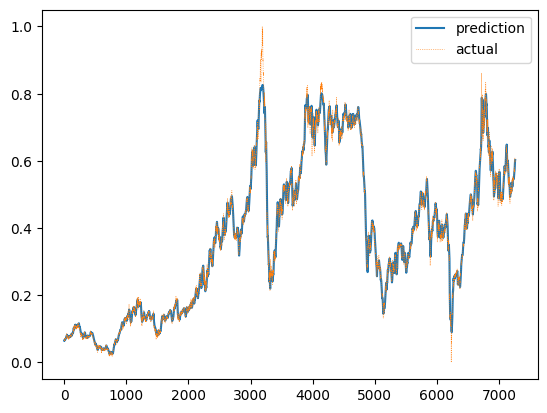

In [61]:
plt.plot(preds, label="prediction")
plt.plot(dataset.data[step:], label="actual", ls=":", lw=0.5)
plt.legend()
plt.show()


In [62]:
preds = []  # 예측값들을 저장하는 리스트
pred_model = torch.load("oil_price_model.pth")
start = dataset[0][0]
with torch.no_grad():
    for i in range(8000):
        pred = pred_model(start.unsqueeze(0))
        start = torch.cat((start[1:], pred))
        preds.append(pred.item())


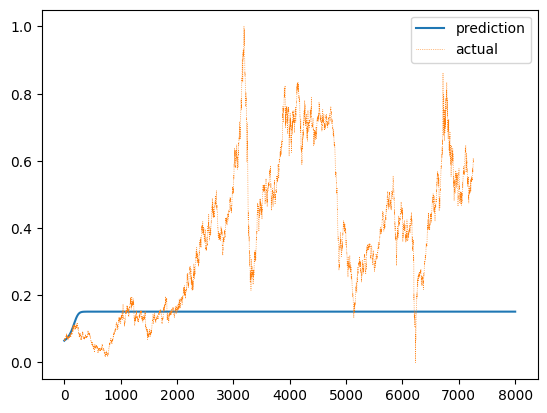

In [65]:
plt.plot(preds, label="prediction")
plt.plot(dataset.data[step:], label="actual", ls=":", lw=0.5)
plt.legend()
plt.show()
